In [1]:
%matplotlib inline
import matplotlib.pylab

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import os
import mne
import matplotlib
import numpy as np
import pandas as pd
import scipy
import scipy.stats
from pylab import savefig
import matplotlib.pyplot as plt
import copy
import seaborn as sns
import pylab as pl
import re
from IPython.display import display

from glob import glob

pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)

%matplotlib inline

/Users/kevinsitek/miniconda/lib/python2.7/site-packages/pandas/__init__.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from pandas import hashtable, tslib, lib
/Users/kevinsitek/miniconda/lib/python2.7/site-packages/pandas/core/common.py:18: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  import pandas.algos as algos
/Users/kevinsitek/miniconda/lib/python2.7/site-packages/pandas/core/index.py:15: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  import pandas.index as _index
/Users/kevinsitek/miniconda/lib/python2.7/site-packages/pandas/tseries/frequencies.py:15: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  import pandas._period as period
/Users/kevinsitek/miniconda/lib/python2.7/site-packages/pandas/sparse/array.py:16: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from pandas._sparse import BlockIndex, IntIndex
/Users

height has been deprecated.



In [6]:
work_dir = os.path.abspath('/Users/kevinsitek/om/om/scratch/Mon/ksitek/')
voice_dir = os.path.abspath('/Users/kevinsitek/om/om/project/voice/processedData/')
tracula_dir = os.path.join(voice_dir, 'tracula')
probtrackx_dir = os.path.join(voice_dir, 'probtrackx')

#subject_list = ['voice999']
subject_list = [os.path.basename(x) for x in sorted(glob(tracula_dir+'/voice*'))]
print subject_list

['voice852', 'voice854', 'voice856', 'voice857', 'voice859', 'voice862', 'voice864', 'voice867', 'voice871', 'voice872', 'voice873', 'voice875', 'voice877', 'voice880', 'voice884', 'voice886', 'voice891', 'voice893', 'voice894', 'voice895', 'voice896', 'voice897', 'voice898', 'voice899', 'voice974', 'voice975', 'voice978', 'voice979', 'voice980', 'voice981', 'voice982', 'voice983', 'voice984', 'voice986', 'voice987', 'voice988', 'voice989', 'voice990', 'voice991', 'voice992', 'voice993', 'voice994', 'voice995', 'voice996', 'voice998', 'voice999']


In [8]:
if ~os.path.isdir(work_dir):
    os.system("sshfs ksitek@openmind7.mit.edu:/ ~/om -o defer_permissions -ocache=no")

## ProbtrackX2

**Import probtrackx results**

In [9]:
# normalize each subject's connectivity values by the total number of streamlines
def collapse_probtrack_results(waytotal_file, matrix_file):
    with open(waytotal_file) as f:
        waytotal = int(f.read())
    #data = nibabel.load(matrix_file).get_data()
    data = np.loadtxt(matrix_file)
    collapsed = data.sum(axis=0) / waytotal * 100.
    return collapsed

In [10]:
for sx, sub in enumerate(subject_list):    
    sub_dir = os.path.join(probtrackx_dir, sub)    
    matrix_file = os.path.join(sub_dir,'matrix1','_subject_id_%s'%sub,
                               'matrix_seeds_to_all_targets')    
    waytotal_file = os.path.join(sub_dir,'way_total',
                                 '_subject_id_%s'%sub, 'waytotal')
    if not sx:
        target_list_file = os.path.join(sub_dir, 'target_list',
                                       '_subject_id_%s'%sub,
                                       'target_masks.txt')    
        target_list_nii = np.genfromtxt(target_list_file, dtype='string')
        target_list = [s.replace('.nii','') for s in target_list_nii]
        #print target_list

        df = pd.DataFrame(columns=target_list, index=subject_list, dtype='float')
    
    df.loc[sub,:] = collapse_probtrack_results(waytotal_file, matrix_file)


In [11]:
# split into subject groups (before other dataframe modifications - keep in mind)
data_mdd = df.loc[df.index.str.startswith('voice8')]
data_hc = df.loc[df.index.str.startswith('voice9')]

In [12]:
# add 'group' column with MDD = 1, HC = 0
df.loc[df.index.str.startswith('voice8'), 'group'] = 1
df.loc[df.index.str.startswith('voice9'), 'group'] = 0


In [13]:
# add 'group-name' column
df.loc[df.index.str.startswith('voice8'), 'group-name'] = 'mdd'
df.loc[df.index.str.startswith('voice9'), 'group-name'] = 'hc'

df.head()

,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus-Proper,Left-Caudate,Left-Putamen,Left-Pallidum,Brain-Stem,Left-Hippocampus,Left-Amygdala,Left-Accumbens-area,...,wm-rh-superiorfrontal,wm-rh-superiorparietal,wm-rh-superiortemporal,wm-rh-supramarginal,wm-rh-frontalpole,wm-rh-temporalpole,wm-rh-transversetemporal,wm-rh-insula,group,group-name
voice852,0,0.00000,0.000163,0.000041,0.000041,0.000000,0.009102,0.000041,0.000000,0.000041,...,0.185592,0.659265,6.365388,4.925224,0.053510,2.661265,1.390041,100,1,mdd
voice854,0,0.00000,0.000000,0.005873,0.000040,0.000040,0.000675,0.000040,0.000000,0.001468,...,0.102341,0.028611,8.405714,5.151905,0.073175,6.199881,1.823849,100,1,mdd
voice856,0,0.00000,0.000094,0.000142,0.000047,0.000047,0.000802,0.000000,0.000000,0.000000,...,0.152170,0.480189,12.783255,3.906415,0.003396,4.913208,4.320236,100,1,mdd
voice857,0,0.00000,0.000079,0.000516,0.000198,0.000119,0.000556,0.000000,0.000000,0.000159,...,0.073095,1.052619,9.410079,4.584762,0.000794,5.647183,2.252659,100,1,mdd
voice859,0,0.00004,0.000081,0.001053,0.000243,0.000324,0.002267,0.000162,0.000162,0.000040,...,0.048745,0.058097,9.993320,5.772713,0.040891,8.867571,3.486640,100,1,mdd


### group differences

In [14]:
# reshape the data for easier plotting with seaborn
melter = pd.melt(df, id_vars=['group-name'], value_vars=df.columns.tolist()[:-2])

In [15]:
# check which connections actually exist
melter[melter['value'] > 0].head()

,group-name,variable,value
13,mdd,Left-Cerebellum-White-Matter,0.000038
18,mdd,Left-Cerebellum-White-Matter,0.000217
22,mdd,Left-Cerebellum-White-Matter,0.000040
27,hc,Left-Cerebellum-White-Matter,0.000323
28,hc,Left-Cerebellum-White-Matter,0.000040


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34]), <a list of 35 Text xticklabel objects>)

/Users/kevinsitek/miniconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


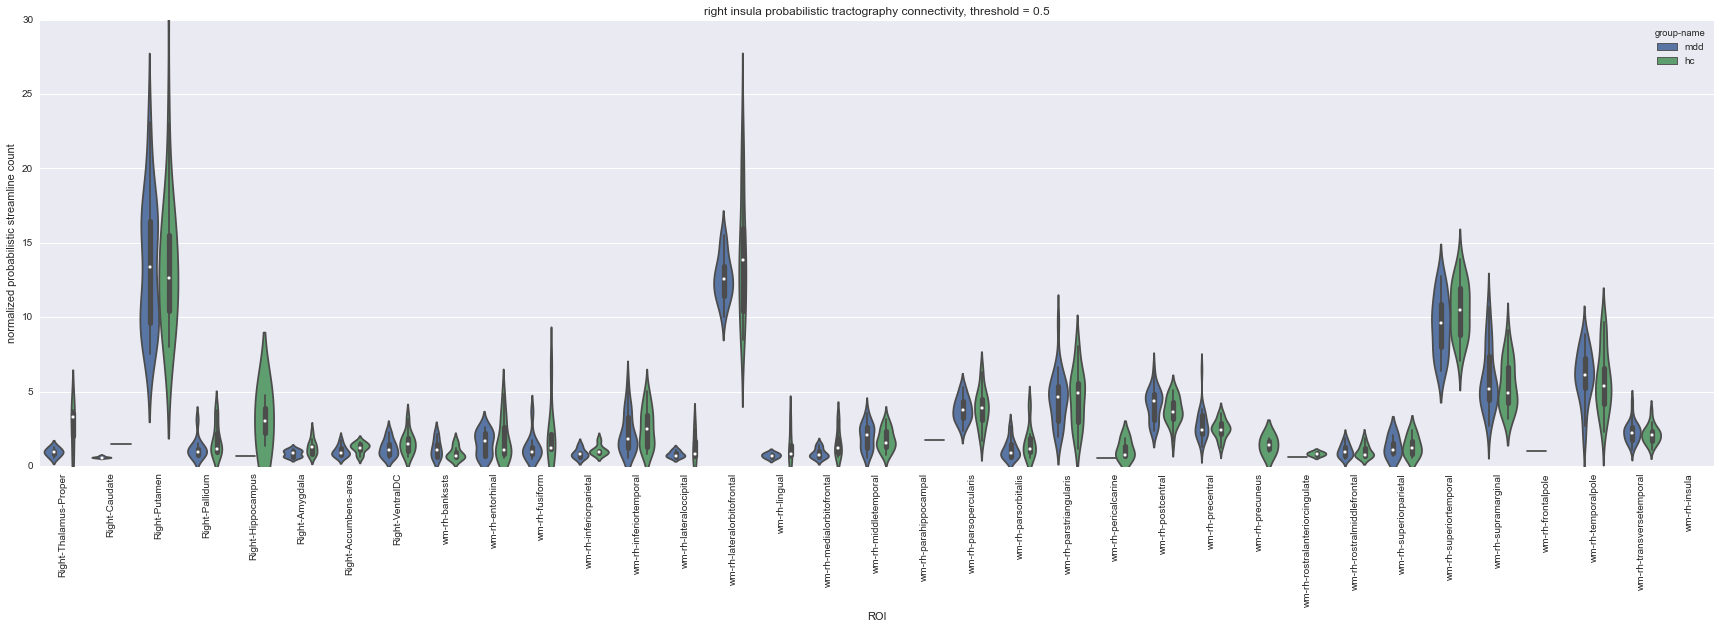

In [16]:
fig = plt.figure(figsize = (30,8));
thresh=.5;
g = sns.violinplot(x='variable',y='value',hue='group-name', 
                   jitter=True, data=melter[melter['value'] > thresh], fig=fig);
g.set(ylim=(0, 30), xlabel='ROI', ylabel='normalized probabilistic streamline count', 
      title='right insula probabilistic tractography connectivity, threshold = %.01f'%thresh);
plt.xticks(rotation=90);
#plt.savefig('plot.png');

In [17]:
# convert to array for simpler statistics computation
data_mdd_array = data_mdd.as_matrix() #
data_hc_array = data_hc.as_matrix()

In [18]:
# run t-test for group differences in right insula connectivity for all target ROIs
roi_num = len(target_list)

t_mat = np.zeros(roi_num)
p_mat = np.zeros(roi_num)
mat = []

for r,roi in enumerate(target_list):
    t, p = scipy.stats.ranksums(data_mdd_array[:,r], data_hc_array[:,r])
    mat.append((t,p))
    
    if p < .10:
        print 'p = %.03f, t = %.02f - %s'%(p, t, roi)
    
    t_mat[r] = t
    p_mat[r] = p

p = 0.086, t = -1.72 - Brain-Stem
p = 0.053, t = -1.94 - Left-VentralDC
p = 0.022, t = -2.30 - Right-Cerebellum-White-Matter
p = 0.086, t = -1.72 - Right-Pallidum
p = 0.018, t = 2.37 - wm-rh-lateraloccipital
p = 0.095, t = -1.67 - wm-rh-medialorbitofrontal
p = 0.022, t = -2.29 - wm-rh-paracentral
p = 0.090, t = 1.69 - wm-rh-pericalcarine
p = 0.045, t = -2.00 - wm-rh-rostralanteriorcingulate
p = 0.068, t = -1.83 - wm-rh-superiortemporal


In [19]:
# FDR correction
from mne.stats import fdr_correction

reject, p_mat_fdr = fdr_correction(p_mat)

#print p_mat_nonan
print 'do any differences survive FDR correction?'
print np.any(reject)
#print reject
print "smallest FDR-corrected p = %.03f" %np.min(p_mat_fdr)

do any differences survive FDR correction?
False
smallest FDR-corrected p = 0.659


**behavioral correlations**

In [20]:
# import bdi scores
behav_dir = os.path.abspath('/Users/kevinsitek/Dropbox (MIT)/projects/voice_personal')
behav_file = os.path.join(behav_dir, '20160108_voicemaster.csv')
behav = pd.read_csv(behav_file)

In [21]:
# create and clean up a bdi dataframe
bdi_df = pd.DataFrame(behav.voice_id)
bdi_df = bdi_df.dropna()
bdi_df['voice_id'] = 'voice' + bdi_df['voice_id'].astype(int).astype(str)
bdi_df['bdi'] = behav.beckdepressionii_total
bdi_df.replace(['n/a'],['NaN'])
bdi_df.head()

,voice_id,bdi
0,voice851,63
1,voice852,27
2,voice854,26
3,voice856,31
4,voice857,16


In [22]:
# merge the probtrackx dataframe with the bdi dataframe
merge_df = bdi_df.merge(df, right_index=True, left_on='voice_id')
merge_df.head()

,voice_id,bdi,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus-Proper,Left-Caudate,Left-Putamen,Left-Pallidum,Brain-Stem,Left-Hippocampus,...,wm-rh-superiorfrontal,wm-rh-superiorparietal,wm-rh-superiortemporal,wm-rh-supramarginal,wm-rh-frontalpole,wm-rh-temporalpole,wm-rh-transversetemporal,wm-rh-insula,group,group-name
1,voice852,27,0,0.00000,0.000163,0.000041,0.000041,0.000000,0.009102,0.000041,...,0.185592,0.659265,6.365388,4.925224,0.053510,2.661265,1.390041,100,1,mdd
2,voice854,26,0,0.00000,0.000000,0.005873,0.000040,0.000040,0.000675,0.000040,...,0.102341,0.028611,8.405714,5.151905,0.073175,6.199881,1.823849,100,1,mdd
3,voice856,31,0,0.00000,0.000094,0.000142,0.000047,0.000047,0.000802,0.000000,...,0.152170,0.480189,12.783255,3.906415,0.003396,4.913208,4.320236,100,1,mdd
4,voice857,16,0,0.00000,0.000079,0.000516,0.000198,0.000119,0.000556,0.000000,...,0.073095,1.052619,9.410079,4.584762,0.000794,5.647183,2.252659,100,1,mdd
6,voice859,15,0,0.00004,0.000081,0.001053,0.000243,0.000324,0.002267,0.000162,...,0.048745,0.058097,9.993320,5.772713,0.040891,8.867571,3.486640,100,1,mdd


### connectivity correlation with BDI

In [23]:
# just look at MDD subjects
merge_df_mdd = merge_df.loc[merge_df.voice_id.str.startswith('voice8')]
merge_df_mdd.bdi = merge_df_mdd.bdi.astype(int)

mdd_bdi_mat = merge_df_mdd.as_matrix(columns=merge_df_mdd.columns[1:-2])
mdd_bdi_mat.shape

/Users/kevinsitek/miniconda/lib/python2.7/site-packages/pandas/core/generic.py:2177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


(23, 90)

In [24]:
# correlations between MDD BDI scores and right insula connectivity for all target ROIs
roi_num = len(target_list)

r_mat_bdi = np.zeros(roi_num)
p_mat_bdi = np.zeros(roi_num)
mat = []

for rx,roi in enumerate(target_list):
    r, p = scipy.stats.spearmanr(mdd_bdi_mat[:,0], mdd_bdi_mat[:,rx+1])
    r = np.arctanh(r)
    mat.append((r,p))
    
    if p < .10:
        print 'p = %.03f, r = %.02f - %s'%(p, r, roi)
    
    r_mat_bdi[rx] = t
    p_mat_bdi[rx] = p

p = 0.053, r = -0.43 - Right-Amygdala
p = 0.029, r = -0.49 - Right-VentralDC
p = 0.067, r = 0.41 - wm-lh-inferiorparietal
p = 0.057, r = -0.43 - wm-lh-parahippocampal
p = 0.060, r = 0.42 - wm-lh-parstriangularis
p = 0.094, r = -0.37 - wm-lh-postcentral
p = 0.040, r = 0.46 - wm-lh-frontalpole
p = 0.048, r = 0.44 - wm-rh-bankssts
p = 0.029, r = -0.49 - wm-rh-paracentral


In [25]:
# FDR correction
from mne.stats import fdr_correction

reject, p_mat_bdi_fdr = fdr_correction(p_mat_bdi)

#print p_mat_nonan
print np.any(reject)
print "smallest FDR-corrected p = %.03f" %np.min(p_mat_bdi_fdr)

False
smallest FDR-corrected p = nan


### correlation with task copes values

In [109]:
task=5
contrast=2
copes_mdd = np.zeros((len(glob(os.path.join(voice_dir,
                                            'l1analysis/may2016_model101/',
                                            'model101/task%03d/voice8*'%task))), 1))
all_copes_df = pd.DataFrame()

func_subject_list=[]
sub_type=[]

for si,sx in enumerate(sorted(glob(os.path.join(voice_dir,'l1analysis/may2016_model101/',
                                                'model101/task%03d/voice8*'%task)))):
    sub_id = os.path.basename(sx)
    func_subject_list.append(sub_id)
    if sub_id[5]=='8':
        sub_type.append('mdd')
    elif sub_id[5]=='9':
        sub_type.append('hc')

    mean_txt = os.path.join(voice_dir,
                            'l1analysis/ohbm_bdi/copes_masked/',
                            'task%03d/%s/cope%02d_mean.txt'%(task,sub_id,contrast))
    copes_mdd[si] = np.genfromtxt(mean_txt)

    copes_df = pd.DataFrame(columns=['voice_id','cope', 'group-name'])
    copes_df.loc['voice_id'] = sub_id
    copes_df['cope'] = copes_mdd[si]
    copes_df['group-name'] = 'mdd'
    copes_df.reset_index(inplace=True, drop=True)
    
    all_copes_df = all_copes_df.append(copes_df)
all_copes_df = all_copes_df[all_copes_df.cope<90]

In [110]:
all_copes_df.head()

,voice_id,cope,group-name
0,voice854,-2.271688,mdd
0,voice857,1.017229,mdd
0,voice859,1.741966,mdd
0,voice860,20.414487,mdd
0,voice862,-0.537996,mdd


In [111]:
copes_merge_df = merge_df.merge(all_copes_df)
copes_merge_df.head()

,voice_id,bdi,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus-Proper,Left-Caudate,Left-Putamen,Left-Pallidum,Brain-Stem,Left-Hippocampus,...,wm-rh-superiorparietal,wm-rh-superiortemporal,wm-rh-supramarginal,wm-rh-frontalpole,wm-rh-temporalpole,wm-rh-transversetemporal,wm-rh-insula,group,group-name,cope
0,voice854,26,0,0.00000,0.000000,0.005873,0.000040,0.000040,0.000675,0.000040,...,0.028611,8.405714,5.151905,0.073175,6.199881,1.823849,100,1,mdd,-2.271688
1,voice857,16,0,0.00000,0.000079,0.000516,0.000198,0.000119,0.000556,0.000000,...,1.052619,9.410079,4.584762,0.000794,5.647183,2.252659,100,1,mdd,1.017229
2,voice859,15,0,0.00004,0.000081,0.001053,0.000243,0.000324,0.002267,0.000162,...,0.058097,9.993320,5.772713,0.040891,8.867571,3.486640,100,1,mdd,1.741966
3,voice862,34,0,0.00000,0.000244,0.003422,0.000041,0.000041,0.000122,0.000000,...,0.127780,10.912790,10.709328,0.005499,4.537963,2.040896,100,1,mdd,-0.537996
4,voice864,17,0,0.00000,0.000418,0.003118,0.004259,0.003346,0.003916,0.000951,...,0.288137,9.915247,5.190570,0.001293,7.673080,2.627376,100,1,mdd,5.587402


In [159]:
# correlations between task right insula copes values and right insula connectivity for all target ROIs
roi_num = len(target_list)

r_mat_cope = np.zeros(roi_num)
p_mat_cope = np.zeros(roi_num)
mat = []

for rx,roi in enumerate(target_list):
    mdd_roi_cope = copes_merge_df[(copes_merge_df['group-name']=='mdd') ]
    
    r, p = scipy.stats.spearmanr(mdd_roi_cope[roi], mdd_roi_cope['cope'])
    r = np.arctanh(r)
    mat.append((r,p))
    
    if p < .10:
        print 'p = %.03f, r = %.02f - %s'%(p, r, roi)
    
    r_mat_cope[rx] = r
    p_mat_cope[rx] = p

p = 0.037, r = 0.52 - Left-Thalamus-Proper
p = 0.027, r = 0.56 - Left-Hippocampus
p = 0.031, r = 0.54 - Left-Amygdala
p = 0.082, r = 0.44 - wm-lh-entorhinal
p = 0.063, r = 0.47 - wm-lh-parstriangularis
p = 0.008, r = 0.67 - wm-rh-entorhinal
p = 0.087, r = 0.43 - wm-rh-parsopercularis


In [160]:
print p_mat_cope

[ 0.39440565  0.32488654  0.03683754  0.46558516  0.10716243  0.34763478
  0.18524679  0.02748385  0.03134403  0.82510504  0.37870998  0.8676926
  0.95452394  0.32525454  0.96020386  0.66801288  0.70497929  0.75888687
  0.46355364  0.70497929  0.86972271         nan  0.50179941  1.
  0.60006071  0.08154782  0.15539276  0.59115077  0.53357809  0.15848304
  0.80666659  0.93182787  0.15087131  0.97725357  0.79479355  0.36290108
  0.28584217         nan         nan  0.06310989  0.41926802  0.36952536
  0.52351928  0.49221195  0.31057378  0.35447795  0.65195145  0.55796524
  0.28621131  0.48680638         nan  0.23340848  0.49458976  0.28584217
  0.37472036  0.16079939  0.62378734  0.57224556  0.29672364  0.00813931
  0.67850462  0.65757975  0.53275173  0.24439328  0.87534388  0.75888687
  0.80280683  0.98862574  0.32160244  0.59466777  0.32192247  0.08668081
  0.31437157  0.66278889  0.17766546  0.39922263  0.53889897  0.66278889
  0.49526609  0.87534388  0.63689593  0.45910899  0.17518569

In [163]:
# FDR correction
from mne.stats import fdr_correction

wnan = p_mat_cope[np.nonzero(1 - np.isnan(p_mat_cope))[0]]

reject, p_mat_cope_fdr = fdr_correction(wnan)

#reject, p_mat_cope_fdr = fdr_correction(p_mat_cope)

#print p_mat_nonan
print np.any(reject)
#print p_mat_cope_fdr
print "smallest FDR-corrected p = %.03f" %np.min(p_mat_cope_fdr)

False
smallest FDR-corrected p = 0.684


## TRACULA

In [115]:
# tracula didn't finish processing for these subjects
exclude_subs_list = ['voice872', 'voice880', 'voice974', 'voice981']
#exclude_subs_list.append('voice879') # no bdi score

In [116]:
# create a dataframe of tracula output statistics for all subjects & tracts
for sx, sub in enumerate(subject_list):   
    if sub not in exclude_subs_list:
        sub_dpath = os.path.join(tracula_dir, sub, 'dpath')

        if not sx:
            tracts = [os.path.basename(x) for x in sorted(glob(sub_dpath+'/*bbr'))]
            all_tract_stats = pd.DataFrame()
            print tracts
        for tx, tract in enumerate(tracts):
            tract_stats_file = os.path.join(sub_dpath, tract, 
                                            'pathstats.overall.txt')
            tract_stats = pd.read_csv(tract_stats_file, header=13, 
                                      delim_whitespace=True)
            tract_stats['tract'] = re.sub('_.*','',tract)
            tract_stats['voice_id'] = sub
            tract_stats = tract_stats.reset_index()
            tract_stats.rename(columns = ({'index':'measure'}), 
                               inplace=True)
            
            all_tract_stats = all_tract_stats.append(tract_stats)

['fmajor_PP_avg33_mni_bbr', 'fminor_PP_avg33_mni_bbr', 'lh.atr_PP_avg33_mni_bbr', 'lh.cab_PP_avg33_mni_bbr', 'lh.ccg_PP_avg33_mni_bbr', 'lh.cst_AS_avg33_mni_bbr', 'lh.ilf_AS_avg33_mni_bbr', 'lh.slfp_PP_avg33_mni_bbr', 'lh.slft_PP_avg33_mni_bbr', 'lh.unc_AS_avg33_mni_bbr', 'rh.atr_PP_avg33_mni_bbr', 'rh.cab_PP_avg33_mni_bbr', 'rh.ccg_PP_avg33_mni_bbr', 'rh.cst_AS_avg33_mni_bbr', 'rh.ilf_AS_avg33_mni_bbr', 'rh.slfp_PP_avg33_mni_bbr', 'rh.slft_PP_avg33_mni_bbr', 'rh.unc_AS_avg33_mni_bbr']


In [117]:
all_tract_stats.head()

,measure,#,tract,voice_id
0,Count,1500.0000,fmajor,voice852
1,Volume,1188.0000,fmajor,voice852
2,Len_Min,55.0000,fmajor,voice852
3,Len_Max,103.0000,fmajor,voice852
4,Len_Avg,70.9693,fmajor,voice852


In [118]:
bdi_df.head()

,voice_id,bdi
0,voice851,63
1,voice852,27
2,voice854,26
3,voice856,31
4,voice857,16


In [119]:
# add 'group-name' column
all_tract_stats.loc[all_tract_stats.voice_id.str.startswith('voice8'), 'group-name'] = 'mdd'
all_tract_stats.loc[all_tract_stats.voice_id.str.startswith('voice9'), 'group-name'] = 'hc'

In [120]:
# add bdi column
all_tract_stats = all_tract_stats.merge(bdi_df)
all_tract_stats.head(20)

,measure,#,tract,voice_id,group-name,bdi
0,Count,1500.000000,fmajor,voice852,mdd,27
1,Volume,1188.000000,fmajor,voice852,mdd,27
2,Len_Min,55.000000,fmajor,voice852,mdd,27
3,Len_Max,103.000000,fmajor,voice852,mdd,27
4,Len_Avg,70.969300,fmajor,voice852,mdd,27
5,Len_Center,71.000000,fmajor,voice852,mdd,27
6,AD_Avg,0.001382,fmajor,voice852,mdd,27
7,AD_Avg_Weight,0.001409,fmajor,voice852,mdd,27
8,AD_Avg_Center,0.001396,fmajor,voice852,mdd,27
9,RD_Avg,0.000503,fmajor,voice852,mdd,27


### group differences

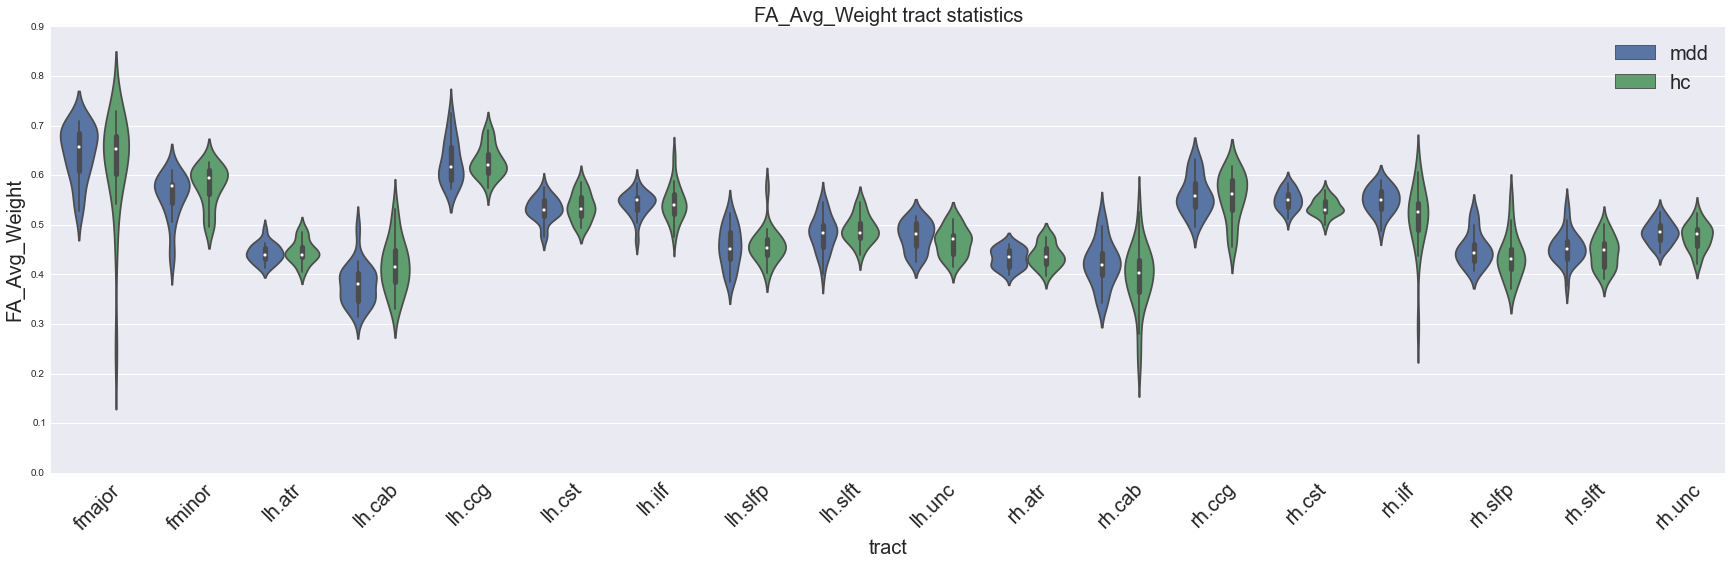

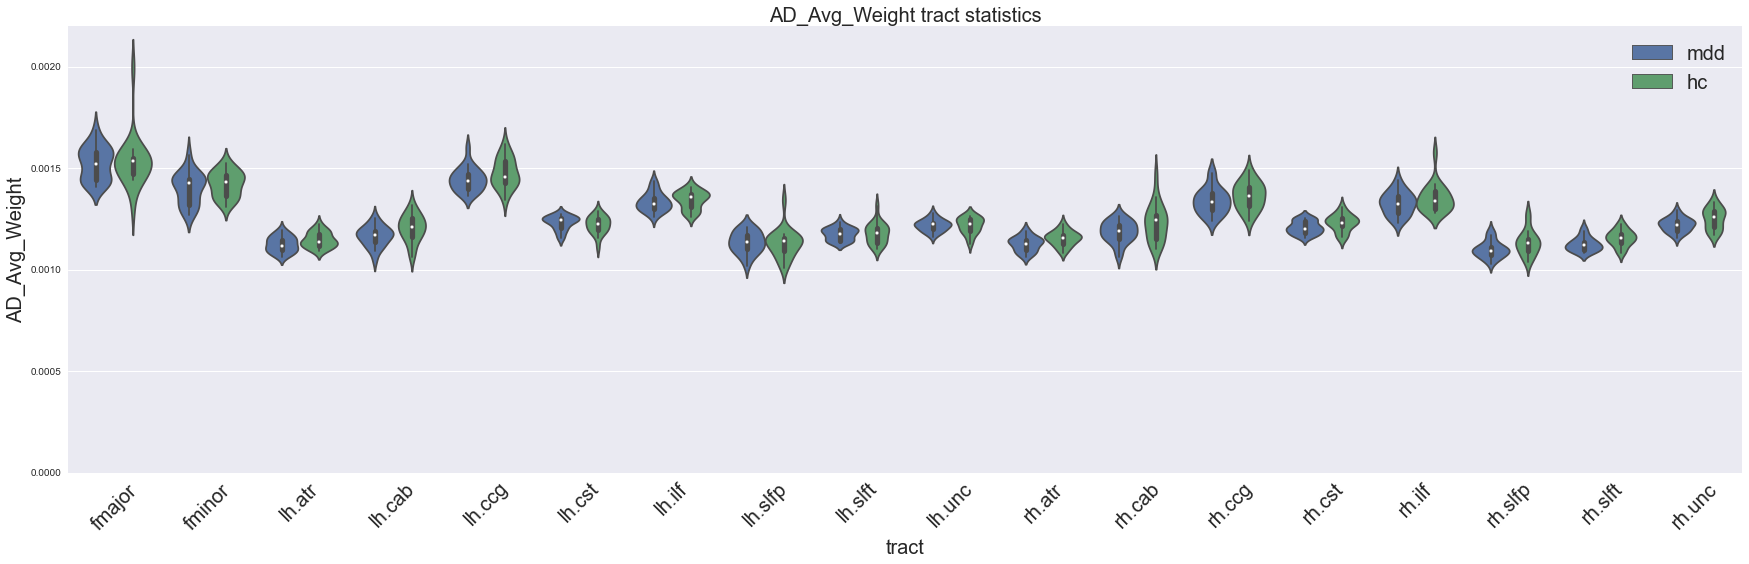

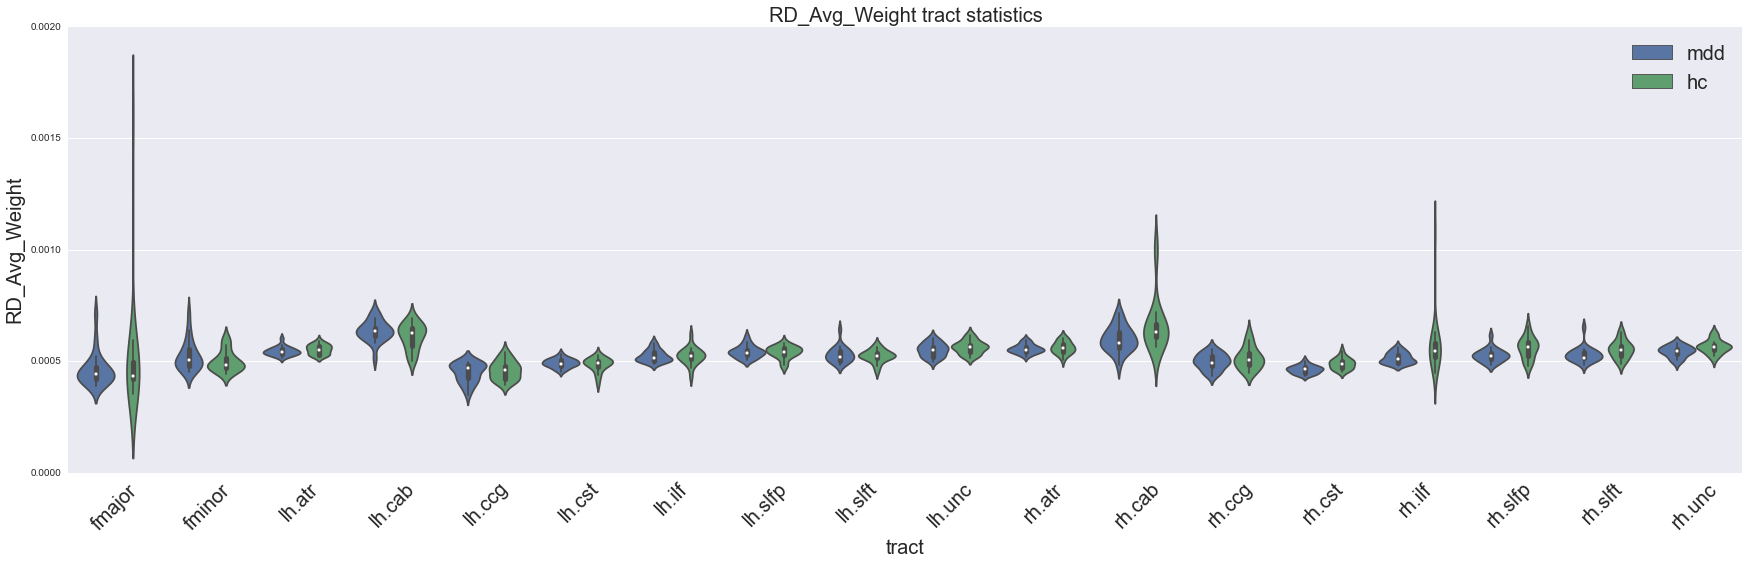

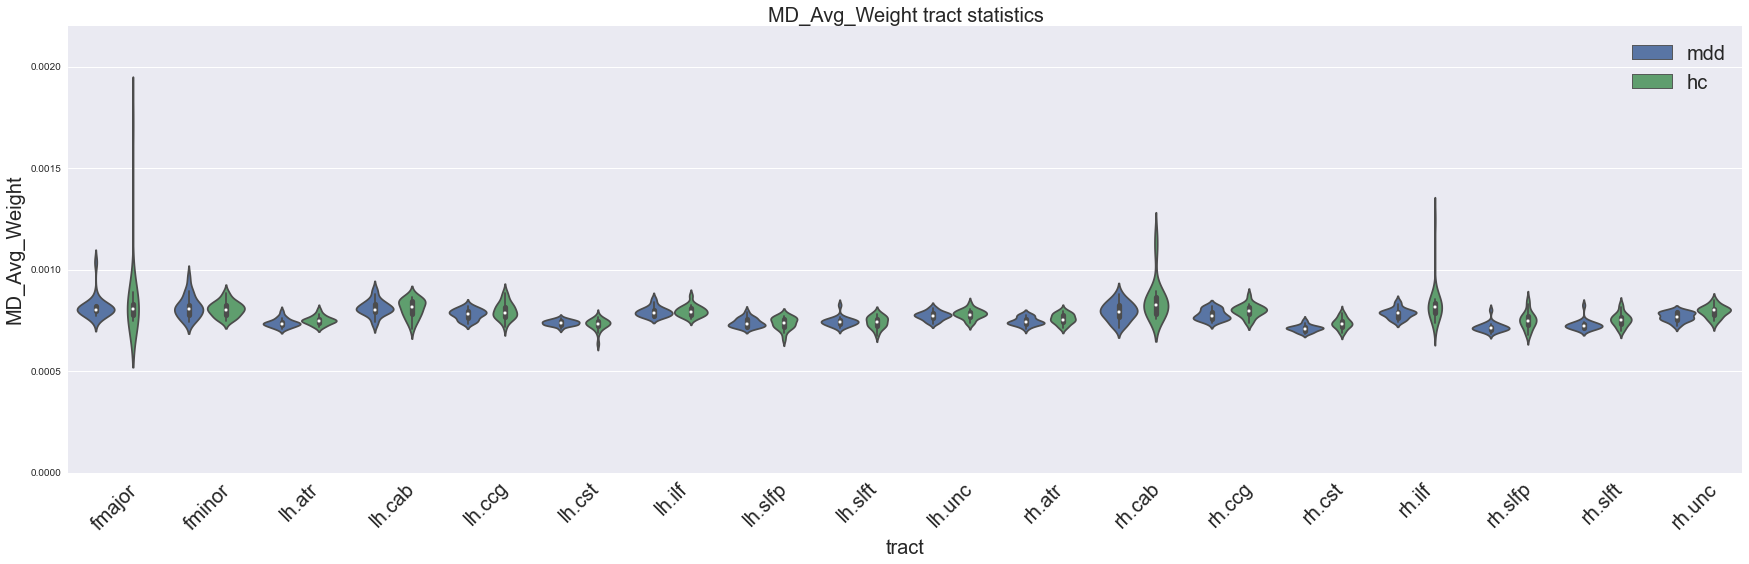

In [121]:
# plot metrics for each tract, comparing groups
for mx, measure in enumerate(['FA_Avg_Weight', 'AD_Avg_Weight', 'RD_Avg_Weight', 'MD_Avg_Weight']):
    fig = plt.figure(figsize = (30,8));
    f = sns.violinplot(x='tract',y='#',hue='group-name', 
                       data = all_tract_stats[all_tract_stats.measure==measure],
                       fig=fig)
    plt.ylim(bottom=0)
    plt.xticks(rotation=45, fontsize=20);
    plt.xlabel('tract', fontsize=20);
    plt.ylabel(measure, fontsize=20);
    plt.title('%s tract statistics'%measure, fontsize=20);
    plt.legend(fontsize=20);

In [122]:
# group difference statistics for TRACULA measures
for mx, measure in enumerate(['FA_Avg_Weight', 'AD_Avg_Weight', 'RD_Avg_Weight', 'MD_Avg_Weight']):
    if mx:
        print '\n'
    print measure
    for tract in np.unique(all_tract_stats.tract):        
        mdd_meas_tract = all_tract_stats[(all_tract_stats['measure']==measure)
                                       & (all_tract_stats['tract']==tract)
                                       & (all_tract_stats['group-name']=='mdd') ]
        hc_meas_tract = all_tract_stats[ (all_tract_stats['measure']==measure)
                                       & (all_tract_stats['tract']==tract)
                                       & (all_tract_stats['group-name']=='hc') ]
        
        t, p = scipy.stats.ranksums(mdd_meas_tract['#'], hc_meas_tract['#'])
        
        print '%.03f, %.02f - %s'%(p, t, tract)

FA_Avg_Weight
0.855, 0.18 - fmajor
0.112, -1.59 - fminor
0.814, -0.23 - lh.atr
0.023, -2.27 - lh.cab
0.696, -0.39 - lh.ccg
0.657, -0.44 - lh.cst
0.639, 0.47 - lh.ilf
0.917, 0.10 - lh.slfp
0.549, -0.60 - lh.slft
0.211, 1.25 - lh.unc
0.549, -0.60 - rh.atr
0.192, 1.30 - rh.cab
0.896, -0.13 - rh.ccg
0.022, 2.30 - rh.cst
0.022, 2.30 - rh.ilf
0.144, 1.46 - rh.slfp
0.419, 0.81 - rh.slft
0.361, 0.91 - rh.unc


AD_Avg_Weight
1.000, 0.00 - fmajor
0.335, -0.97 - fminor
0.095, -1.67 - lh.atr
0.032, -2.14 - lh.cab
0.151, -1.43 - lh.ccg
0.434, 0.78 - lh.cst
0.389, -0.86 - lh.ilf
0.676, 0.42 - lh.slfp
0.938, -0.08 - lh.slft
0.774, -0.29 - lh.unc
0.019, -2.35 - rh.atr
0.095, -1.67 - rh.cab
0.167, -1.38 - rh.ccg
0.064, -1.85 - rh.cst
0.361, -0.91 - rh.ilf
0.057, -1.90 - rh.slfp
0.016, -2.40 - rh.slft
0.068, -1.83 - rh.unc


RD_Avg_Weight
0.979, -0.03 - fmajor
0.192, 1.30 - fminor
0.175, -1.36 - lh.atr
0.297, 1.04 - lh.cab
0.715, -0.37 - lh.ccg
0.774, 0.29 - lh.cst
0.794, -0.26 - lh.ilf
0.876, -0.16 - l

### TRACULA correlations with BDI

In [123]:
# MDD bdi correlations with TRACULA measures
for mx, measure in enumerate(['FA_Avg_Weight', 'AD_Avg_Weight', 'RD_Avg_Weight', 'MD_Avg_Weight']):
    if mx:
        print '\n'
    print measure
    for tract in np.unique(all_tract_stats.tract):        
        mdd_meas_tract = all_tract_stats[(all_tract_stats['measure']==measure)
                                       & (all_tract_stats['tract']==tract)
                                       & (all_tract_stats['group-name']=='mdd') ]
        
        r, p = scipy.stats.spearmanr(mdd_meas_tract['#'], mdd_meas_tract['bdi'].astype(int))
        
        print 'p = %.03f, r = %.02f - %s'%(p, r, tract)

FA_Avg_Weight
p = 0.066, r = -0.41 - fmajor
p = 0.484, r = -0.16 - fminor
p = 0.862, r = -0.04 - lh.atr
p = 0.373, r = -0.21 - lh.cab
p = 0.506, r = 0.15 - lh.ccg
p = 0.762, r = 0.07 - lh.cst
p = 0.348, r = 0.22 - lh.ilf
p = 0.147, r = -0.33 - lh.slfp
p = 0.404, r = -0.19 - lh.slft
p = 0.479, r = -0.16 - lh.unc
p = 0.635, r = 0.11 - rh.atr
p = 0.331, r = -0.22 - rh.cab
p = 0.202, r = 0.29 - rh.ccg
p = 0.172, r = 0.31 - rh.cst
p = 0.233, r = 0.27 - rh.ilf
p = 0.599, r = -0.12 - rh.slfp
p = 0.816, r = -0.05 - rh.slft
p = 0.603, r = -0.12 - rh.unc


AD_Avg_Weight
p = 0.886, r = 0.03 - fmajor
p = 0.079, r = 0.39 - fminor
p = 0.605, r = 0.12 - lh.atr
p = 0.568, r = -0.13 - lh.cab
p = 0.701, r = 0.09 - lh.ccg
p = 0.403, r = 0.19 - lh.cst
p = 0.028, r = 0.48 - lh.ilf
p = 0.245, r = -0.27 - lh.slfp
p = 0.298, r = -0.24 - lh.slft
p = 0.924, r = -0.02 - lh.unc
p = 0.448, r = 0.18 - rh.atr
p = 0.424, r = -0.18 - rh.cab
p = 0.360, r = 0.21 - rh.ccg
p = 0.165, r = 0.31 - rh.cst
p = 0.033, r = 0.47 

### Correlations with task right insula copes

In [142]:
copes_merge_trac_df = all_tract_stats.merge(all_copes_df)
copes_merge_trac_df.head(20)

,measure,#,tract,voice_id,group-name,bdi,cope
0,Count,1500.000000,fmajor,voice854,mdd,26,-2.271688
1,Volume,643.000000,fmajor,voice854,mdd,26,-2.271688
2,Len_Min,48.000000,fmajor,voice854,mdd,26,-2.271688
3,Len_Max,88.000000,fmajor,voice854,mdd,26,-2.271688
4,Len_Avg,67.096000,fmajor,voice854,mdd,26,-2.271688
5,Len_Center,66.000000,fmajor,voice854,mdd,26,-2.271688
6,AD_Avg,0.001514,fmajor,voice854,mdd,26,-2.271688
7,AD_Avg_Weight,0.001524,fmajor,voice854,mdd,26,-2.271688
8,AD_Avg_Center,0.001490,fmajor,voice854,mdd,26,-2.271688
9,RD_Avg,0.000493,fmajor,voice854,mdd,26,-2.271688


In [152]:
# correlations between task right insula copes values and right insula connectivity for all target ROIs

#roi_num = len(target_list)
#
#r_mat_tract_cope = np.zeros(roi_num)
#p_mat_tract_cope = np.zeros(roi_num)
mat = []
for mx, measure in enumerate(['FA_Avg_Weight', 'AD_Avg_Weight', 'RD_Avg_Weight', 'MD_Avg_Weight']):
    if mx:
        print '\n'
    print measure
    
    for tract in np.unique(copes_merge_trac_df.tract):  
        mdd_tract_cope = copes_merge_trac_df[(copes_merge_trac_df['measure']==measure)
                                       & (copes_merge_trac_df['tract']==tract)
                                       & (copes_merge_trac_df['group-name']=='mdd') ]

        r, p = scipy.stats.spearmanr(mdd_tract_cope['#'], mdd_tract_cope['cope'])
        r = np.arctanh(r)
        mat.append((r,p))

        print 'p = %.03f, r = %.02f - %s'%(p, r, tract)

        #r_mat_tract_cope[rx] = r
        #p_mat_tract_cope[rx] = p

FA_Avg_Weight
p = 0.619, r = -0.13 - fmajor
p = 0.165, r = 0.37 - fminor
p = 0.158, r = -0.37 - lh.atr
p = 0.889, r = -0.04 - lh.cab
p = 0.422, r = 0.21 - lh.ccg
p = 0.486, r = -0.18 - lh.cst
p = 0.374, r = 0.23 - lh.ilf
p = 0.844, r = -0.05 - lh.slfp
p = 0.837, r = 0.05 - lh.slft
p = 0.808, r = 0.06 - lh.unc
p = 0.554, r = -0.16 - rh.atr
p = 0.837, r = 0.05 - rh.cab
p = 0.094, r = 0.45 - rh.ccg
p = 0.758, r = -0.08 - rh.cst
p = 0.560, r = 0.15 - rh.ilf
p = 0.112, r = -0.42 - rh.slfp
p = 0.084, r = -0.46 - rh.slft
p = 0.694, r = -0.10 - rh.unc


AD_Avg_Weight
p = 0.993, r = 0.00 - fmajor
p = 0.660, r = -0.12 - fminor
p = 0.052, r = -0.52 - lh.atr
p = 0.772, r = -0.08 - lh.cab
p = 0.439, r = 0.20 - lh.ccg
p = 0.462, r = -0.19 - lh.cst
p = 0.462, r = 0.19 - lh.ilf
p = 0.155, r = -0.38 - lh.slfp
p = 0.260, r = -0.30 - lh.slft
p = 0.619, r = -0.13 - lh.unc
p = 0.133, r = -0.40 - rh.atr
p = 0.305, r = 0.27 - rh.cab
p = 0.117, r = 0.42 - rh.ccg
p = 0.358, r = -0.24 - rh.cst
p = 0.715, r = 0.